In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from astropy.table import Table

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

# The Goal:
Remake this plot that Schmidt and I made one evening, many years ago.... but with MORE data!

Then, have a tool to compute metallicity for "all" Gaia stars!

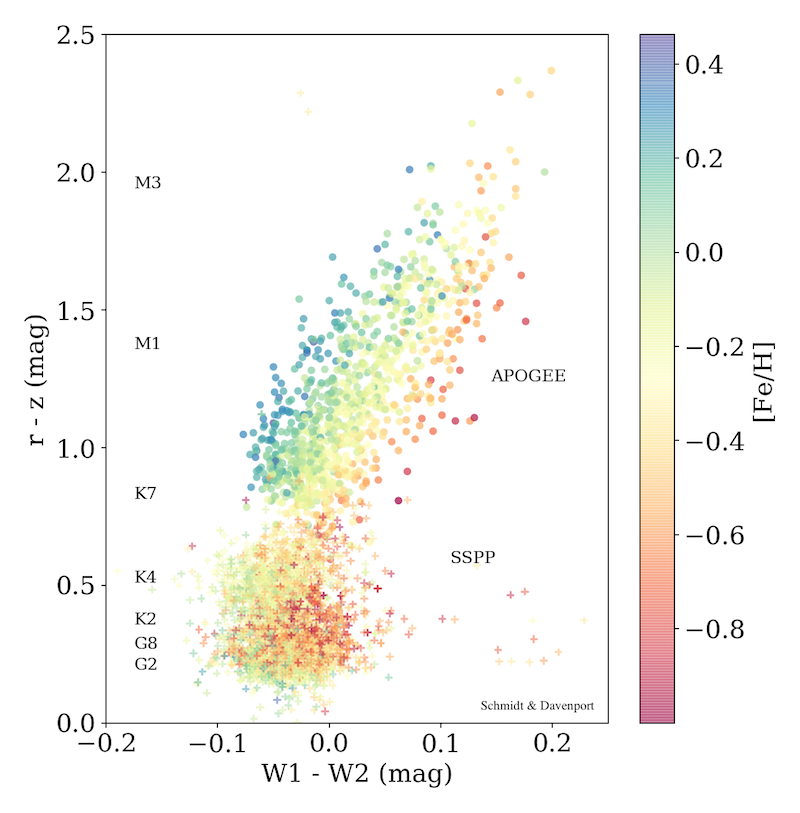

In [3]:
from IPython.display import Image
Image(filename='./w1w2_rz_feh.png', width=500) 

## Step 1: X-match
We need to combine the SSPP and APOGEE properties tables with:
- Gaia DR2
- AllWISE

Hopefully both tables have SDSS colors.......

**Q:** Can I combine both `(ra,dec)` lists and do 1 X-match for both catalogs?

### SDSS first

In [4]:
# #umm... are these dwarfs? Nothing with logg>=4... boo
# da = np.where((apog['LOGG'] >= 3.3) & (apog['FE_H'] > -5))[0]

# plt.scatter(apog['TEFF'][da], apog['J'][da] - apog['WISE_4_5'][da], 
#             c=apog['FE_H'][da], s=5, alpha=0.5)
# plt.ylim(0,1.5)
# plt.xlim(5700,4000)
# plt.ylabel('J - W2')
# plt.xlabel('Teff')
# cb=plt.colorbar()
# cb.set_label('[Fe/H]')

In [63]:
sdss = Table.read('/Users/james/Desktop/gaia_tmp/ssppOut-dr12.fits', format='fits')

(6, -2)

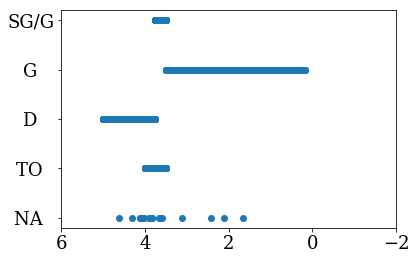

In [64]:
plt.scatter(sdss['LOGG_ADOP'], sdss['L_CLASS'])
plt.xlim(6,-2)

In [65]:
xyok = np.where((sdss['RA'] >= 0) & (sdss['RA'] <= 360) & 
                (sdss['DEC'] >= -90) & (sdss['DEC'] <= 90))[0]
# df_out = pd.DataFrame(data={'ra':sdss['RA'][xyok], 'dec':sdss['DEC'][xyok]})
# df_out.to_csv('sspp_toX.csv')

In [66]:
Xgaia = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xgaia.csv')
Xwise = pd.read_csv('/Users/james/Desktop/gaia_tmp/Xwise.csv')

df = sdss[xyok].to_pandas()
tmp_data = pd.merge(Xgaia, Xwise, left_on=u'id', right_on=u'id')
data = pd.merge(df, tmp_data, how='inner', left_on=np.arange(len(df)), right_on=u'id')

In [106]:
ok = np.where((data[u'parallax_error']/data[u'parallax'] <= 0.02) & 
              (data[u'parallax'] > 0) & 
              np.isfinite(data[u'phot_g_mean_mag']) & 
              np.isfinite(data[u'phot_bp_mean_mag']) & 
              np.isfinite(data[u'phot_rp_mean_mag']))[0]
print(np.shape(ok))

(8438,)


In [98]:
# plt.figure(figsize=(9,8))
# plt.scatter(1000./data[u'parallax'][ok], data[u'DIST_ADOP'][ok]*1000., s=2, alpha=0.15, 
#             c=data[u'parallax_error'][ok]/data[u'parallax'][ok])
# plt.xlabel('Gaia 1/plx (pc)')
# plt.ylabel('SDSS DIST_ADOP (pc)')
# plt.plot([1,1e4], [1,1e4])
# cb = plt.colorbar()
# cb.set_label('frac. plx. err.')
# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(1e2,1e4)
# plt.xlim(1e2,1e4)
# plt.title('SSPP sources')

Text(0,0.5,'$M_G$ (mag)')

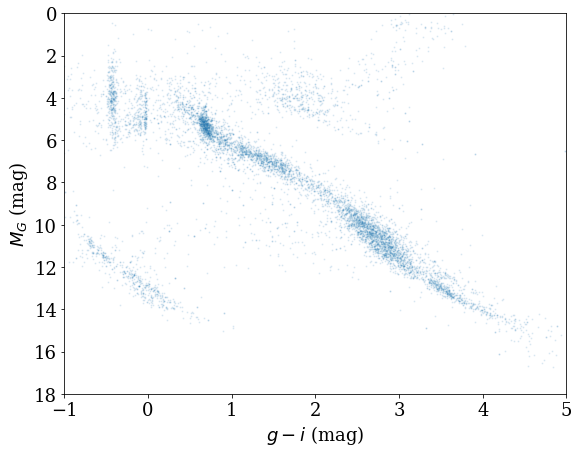

In [107]:
plt.figure(figsize=(9,7))

plt.scatter(data[u'GR'].values[ok]+data[u'RI'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=1, alpha=0.1)
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$g-i$ (mag)')
plt.ylabel(r'$M_G$ (mag)')

(1.5, 3.5)

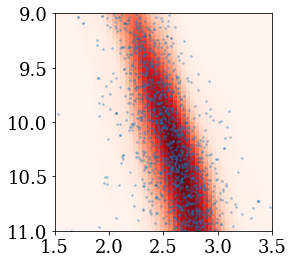

In [114]:
# yet another aside... 
# try to see the new "Jao gap" for M4 stars in the SDSS data...
from scipy import stats
X, Y = np.mgrid[1.5:3.5:50j, 9:11:50j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([data[u'phot_bp_mean_mag'].values[ok] - data[u'phot_rp_mean_mag'].values[ok], 
                    (data[u'phot_g_mean_mag'].values[ok] - 
                     5*np.log10(1000./data[u'parallax'].values[ok])+5)])
kernel = stats.gaussian_kde(values)
kernel.set_bandwidth(bw_method=kernel.factor / 3.)
Z = np.reshape(kernel(positions).T, X.shape)

plt.imshow(np.rot90(Z), extent=[1.5, 3.5, 9, 11], cmap=plt.cm.Reds)
plt.scatter(data[u'phot_bp_mean_mag'].values[ok] - data[u'phot_rp_mean_mag'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=3, alpha=0.3)
plt.ylim(11, 9)
plt.xlim(1.5,3.5)



Text(0,0.5,'$M_G$ (mag)')

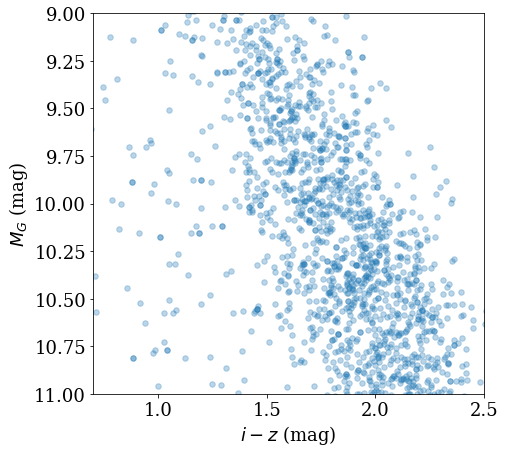

In [101]:
plt.figure(figsize=(7,7))

plt.scatter(data[u'RI'].values[ok]+data[u'IZ'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=30, alpha=0.3)
plt.ylim(11, 9)
plt.xlim(.7,2.5)
plt.xlabel('$i-z$ (mag)')
plt.ylabel(r'$M_G$ (mag)')

Text(0.5,1,'SDSS stars, $\\sigma/\\pi<0.02$')

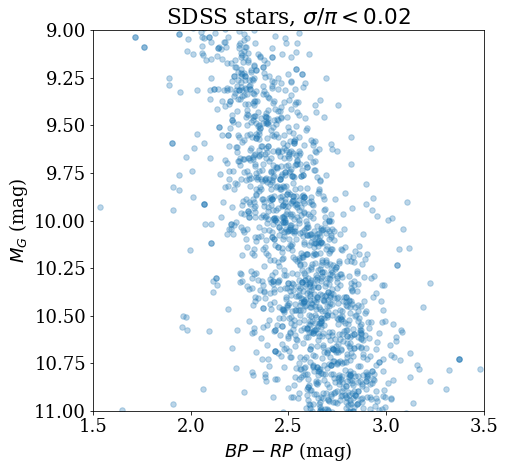

In [103]:
plt.figure(figsize=(7,7))

plt.scatter(data[u'phot_bp_mean_mag'].values[ok] - data[u'phot_rp_mean_mag'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=30, alpha=0.3)
plt.ylim(11, 9)
plt.xlim(1.5,3.5)
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
plt.title('SDSS stars, $\sigma/\pi<0.02$')

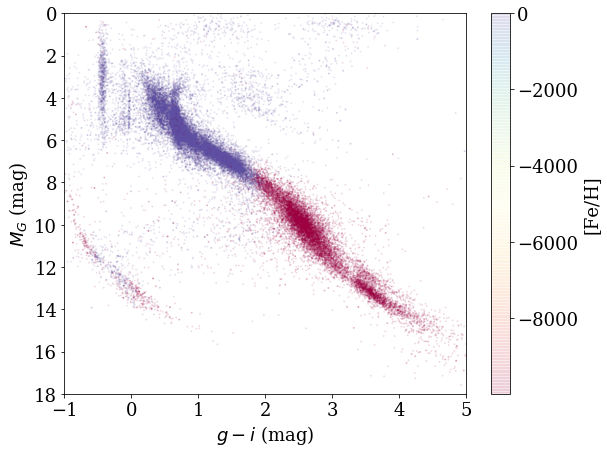

In [85]:
plt.figure(figsize=(9,7))

plt.scatter(data[u'GR'].values[ok]+data[u'RI'].values[ok], 
            (data[u'phot_g_mean_mag'].values[ok] - 
             5*np.log10(1000./data[u'parallax'].values[ok])+5),
            s=1, alpha=0.1, c=data[u'FEH_ADOP'].values[ok], cmap=plt.cm.Spectral)
cb = plt.colorbar()
plt.ylim(18,0)
plt.xlim(-1,5)
plt.xlabel('$g-i$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

In [12]:
# fok = np.where((data[u'FEH_ADOP'].values[ok] > -6))

# M_G = (data[u'phot_g_mean_mag'].values[ok] - 
#        5*np.log10(1000./data[u'parallax'].values[ok])+5)

# plt.figure(figsize=(9,7))

# plt.scatter(data[u'GR'].values[ok][fok]+data[u'RI'].values[ok][fok], 
#             M_G[fok],
#             s=2, alpha=0.2, c=data[u'LOGG_ADOP'].values[ok][fok], cmap=plt.cm.Spectral)

# cb = plt.colorbar()
# plt.ylim(18,0)
# plt.xlim(-1,5)
# plt.xlabel('$g-i$ (mag)')
# plt.ylabel(r'$M_G$ (mag)')
# cb.set_label('log g')

In [13]:
# gok = np.where((data[u'FEH_ADOP'].values[ok] > -6) & 
#                (M_G > 4) & (M_G < 9) & 
#                np.isfinite(data[u'a_g_val'].values[ok]) & 
#                (data[u'a_g_val'].values[ok] < 0.5))


In [14]:
# plt.figure(figsize=(9,7))
# plt.scatter(data[u'GR'].values[ok][gok] + data[u'RI'].values[ok][gok], 
#             data[u'UG'].values[ok][gok],
#             c=data[u'FEH_ADOP'].values[ok][gok], s=2, alpha=0.5, cmap=plt.cm.coolwarm)

# cb = plt.colorbar()
# cb.set_label('[Fe/H]')
# cb.set_clim((-2,1))
# plt.xlim(0,2)
# plt.ylim(0.5,3)
# plt.ylabel('$u-g$')
# plt.xlabel('$g-i$')

In [15]:
# plt.figure(figsize=(9,7))
# plt.scatter(data[u'phot_g_mean_mag'].values[ok][gok] - data[u'Jmag'].values[ok][gok], 
#             data[u'UG'].values[ok][gok],
#             c=data[u'FEH_ADOP'].values[ok][gok], s=2, alpha=0.5, cmap=plt.cm.coolwarm)

# cb = plt.colorbar()
# cb.set_label('[Fe/H]')
# cb.set_clim((-2,1))
# plt.xlim(0,3)
# plt.ylim(0.5,3)
# plt.ylabel('$u-g$')
# plt.xlabel('$G-J$')

### APOGEE next

In [16]:
apog = Table.read('/Users/james/Desktop/gaia_tmp/allStar-l31c.2.fits', format='fits')

In [17]:
# apog.colnames

In [18]:
xyokA = np.where((apog['RA'] >= 0) & (apog['RA'] <= 360) & 
                 (apog['DEC'] >= -90) & (apog['DEC'] <= 90))[0]
# df_outA = pd.DataFrame(data={'ra':apog['RA'][xyokA], 'dec':apog['DEC'][xyokA]})
# df_outA.to_csv('apog_toX.csv')

In [19]:
Agaia = pd.read_csv('/Users/james/Desktop/gaia_tmp/Agaia.csv')
Awise = pd.read_csv('/Users/james/Desktop/gaia_tmp/Awise.csv')

In [20]:
# need to select out columns i want, b/c multi-D cols messing .to_pandas up...
# can fix later...

dfA = apog[xyokA]['J','J_ERR','H', 'H_ERR', 'K', 'K_ERR', 'VSINI',
                  'RA', 'DEC', 'GLON', 'GLAT', 'TEFF', 'LOGG', 'FE_H'].to_pandas()


In [21]:
tmp_dataA = pd.merge(Agaia, Awise, left_on=u'id', right_on=u'id')
Adata = pd.merge(dfA, tmp_dataA, how='inner', left_on=np.arange(len(dfA)), right_on=u'id')

In [22]:
# Adata.columns

In [23]:
Aok = np.where((Adata[u'FE_H'] > -6))

M_GA = (Adata[u'phot_g_mean_mag'].values[Aok] - 
        5*np.log10(1000./Adata[u'parallax'].values[Aok])+5)

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


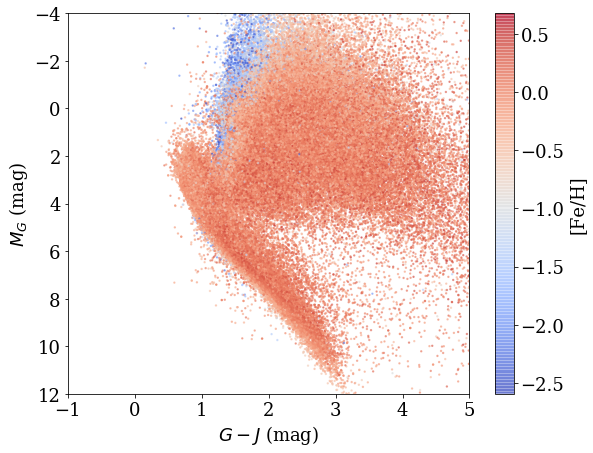

In [24]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values[Aok] - Adata[u'Jmag'].values[Aok], 
            M_GA,
            s=2, alpha=0.5, c=Adata[u'FE_H'].values[Aok], cmap=plt.cm.coolwarm)

cb = plt.colorbar()
plt.ylim(12,-4)
plt.xlim(-1,5)
plt.xlabel('$G-J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')

Text(0,0.5,'$M_G$ (mag)')

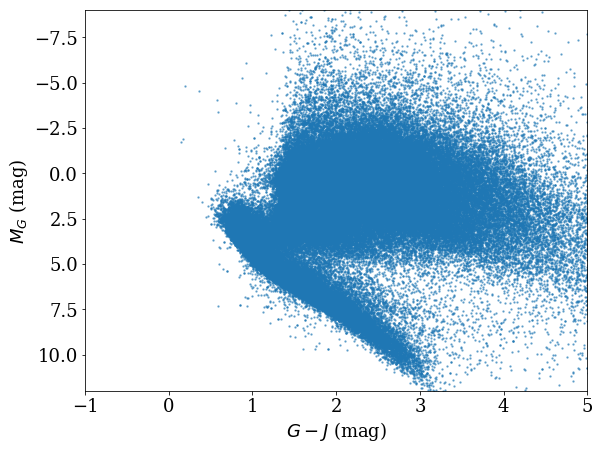

In [25]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values[Aok] - Adata[u'Jmag'].values[Aok], 
            M_GA,
            s=2, alpha=0.5)

plt.ylim(12,-9)
plt.xlim(-1,5)
plt.xlabel('$G-J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')


uh oh.... no mid-M dwarfs in APOGEE.... oh well

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in divide
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


Text(0.5,1,'APOGEE stars (all)')

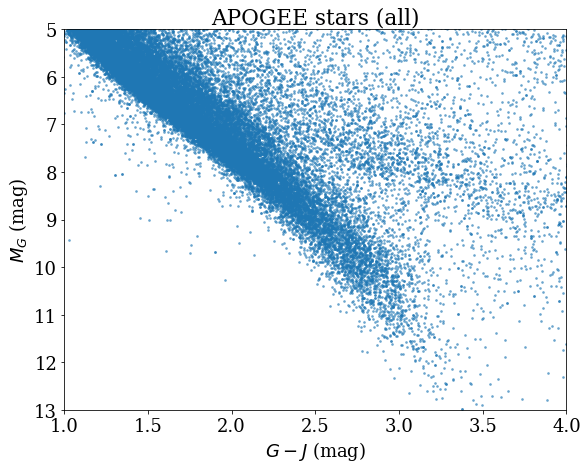

In [62]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values - Adata[u'Jmag'].values, 
            (Adata[u'phot_g_mean_mag'].values - 5*np.log10(1000./Adata[u'parallax'].values)+5),
            s=3, alpha=0.5)

plt.ylim(13,5)
plt.xlim(1,4)
plt.xlabel('$G - J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
plt.title('APOGEE stars (all)')

Text(0.5,1,'APOGEE stars')

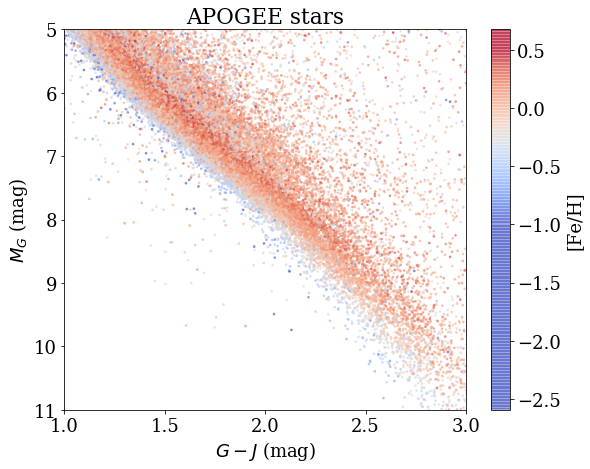

In [26]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values[Aok] - Adata[u'Jmag'].values[Aok], 
            M_GA,
            s=3, alpha=0.5, c=Adata[u'FE_H'].values[Aok], cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_clim(-1,0.5)
plt.ylim(11,5)
plt.xlim(1,3)
plt.xlabel('$G - J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')
cb.set_label('[Fe/H]')
plt.title('APOGEE stars')

Text(0,0.5,'$M_G$ (mag)')

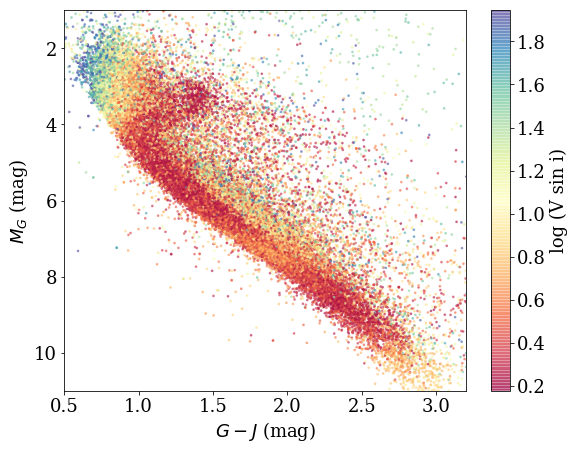

In [27]:
vok = np.where((Adata[u'VSINI'].values[Aok] > -10))
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_g_mean_mag'].values[Aok][vok] - Adata[u'Jmag'].values[Aok][vok], 
            M_GA[vok],
            s=3, alpha=0.5, c=np.log10(Adata[u'VSINI'].values[Aok][vok]), cmap=plt.cm.Spectral)

cb = plt.colorbar()
# cb.set_clim(0,10)
cb.set_label('log (V sin i)')
plt.ylim(11, 1)
plt.xlim(0.5, 3.2)
plt.xlabel('$G - J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')


Text(0,0.5,'$M_G$ (mag)')

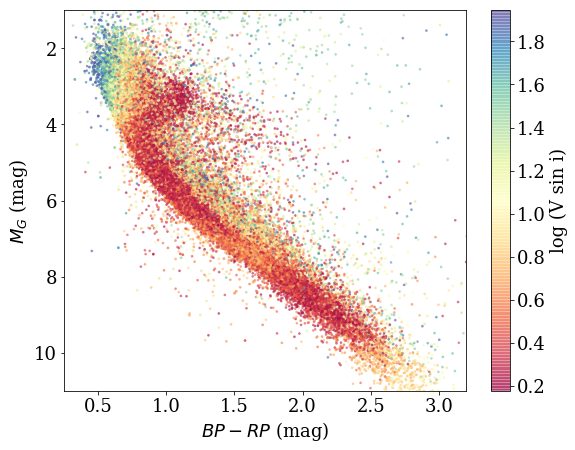

In [28]:
plt.figure(figsize=(9,7))

plt.scatter(Adata[u'phot_bp_mean_mag'].values[Aok][vok] - Adata[u'phot_rp_mean_mag'].values[Aok][vok], 
            M_GA[vok],
            s=3, alpha=0.5, c=np.log10(Adata[u'VSINI'].values[Aok][vok]), cmap=plt.cm.Spectral)

cb = plt.colorbar()
# cb.set_clim(0,10)
cb.set_label('log (V sin i)')
plt.ylim(11, 1)
plt.xlim(0.25, 3.2)
plt.xlabel('$BP - RP$ (mag)')
plt.ylabel(r'$M_G$ (mag)')



/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


Text(0,0.5,'$G-J$ (mag)')

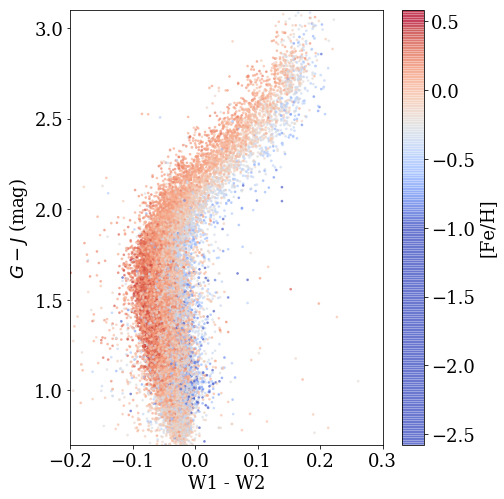

In [29]:
Bok = np.where((M_GA >= 3) & 
               np.isfinite(Adata[u'a_g_val'].values[Aok]) & 
               (Adata[u'a_g_val'].values[Aok] < 0.5))

plt.figure(figsize=(7,8))

plt.scatter(Adata[u'W1mag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok], 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

In [30]:
#teff, logg, microturb, m/H, alpha/m,...
apog['FPARAM'][0]

array([ 5.6874e+03,  4.4109e+00, -2.1747e-01, -4.2787e-03,  0.0000e+00,
        0.0000e+00, -7.9334e-03,  5.0445e-01,  0.0000e+00], dtype=float32)

In [31]:
# one of these has [Fe/H]
apog['FELEM'][0]

array([ 5.1644e-03, -5.8704e-02,  1.0632e-02, -3.2022e-03, -9.5010e-04,
       -3.1959e-02,  3.7645e-02, -7.8423e-03, -2.9916e-02, -8.6147e-03,
       -6.9795e-02, -1.3100e-02, -4.6723e-02,  2.1299e-01,  7.3351e-02,
       -2.4195e+00, -5.1991e-02, -8.6715e-03,  3.9896e-01,  4.7643e-02,
        2.0401e-03, -2.4637e+00, -9.9990e+03, -2.1771e+00, -3.7369e-02,
        1.1332e-01], dtype=float32)

In [32]:
apog['SNREV'][0]

444.07825

In [33]:
# first, start w/ STAR_BAD flag set = 0 

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


Text(0,0.5,'$G-J$ (mag)')

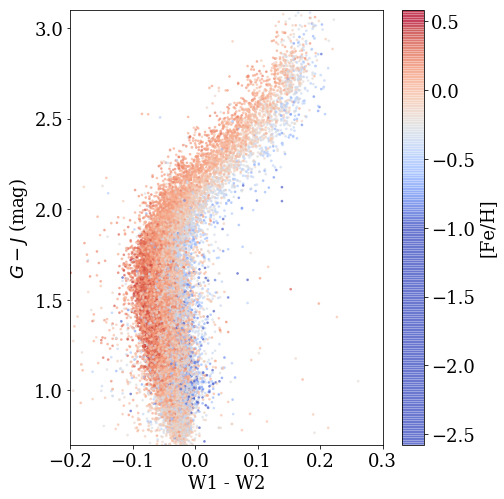

In [34]:
# GOAL: make this w/ the exrta stars below the normal limits using the "FELEM" value
# use stars w/ SNREV >= 50ish (s/n limit)

Bok = np.where((M_GA >= 3) & 
               np.isfinite(Adata[u'a_g_val'].values[Aok]) & 
               (Adata[u'a_g_val'].values[Aok] < 0.5))

plt.figure(figsize=(7,8))

plt.scatter(Adata[u'W1mag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok], 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

## Model
can we build a model of it? A goal for Thursday!

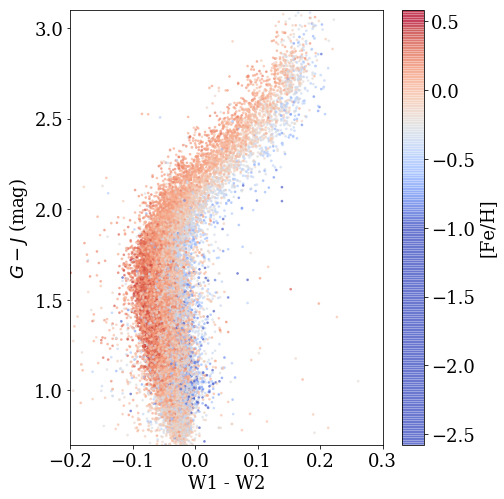

In [35]:
plt.figure(figsize=(7,8))

fitok = np.where((Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok] < 3.3) & 
                 (Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok] > 0))

plt.scatter(Adata[u'W1mag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok], 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

fit = np.polyfit((Adata[u'phot_g_mean_mag'].values[Aok][Bok][fitok] - 
                  Adata[u'Jmag'].values[Aok][Bok][fitok]), 
                 (Adata[u'W1mag'].values[Aok][Bok][fitok] - 
                  Adata[u'W2mag'].values[Aok][Bok][fitok]), 4)
# plt.plot(np.polyval(fit,np.arange(0,3.2,0.1)), np.arange(0,3.2,0.1))

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')
plt.savefig('ingot.png')

Text(0,0.5,'$G-J$ (mag)')

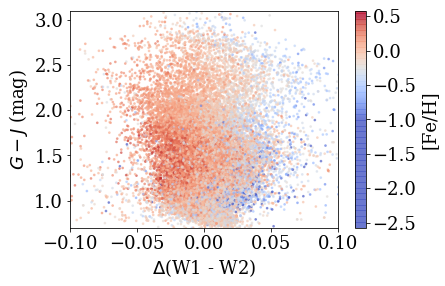

In [36]:
plt.scatter((Adata[u'W1mag'].values[Aok][Bok] - Adata[u'W2mag'].values[Aok][Bok] - 
             np.polyval(fit, Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok])), 
            Adata[u'phot_g_mean_mag'].values[Aok][Bok] - Adata[u'Jmag'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)
plt.xlim(-0.1,0.1)
plt.ylim(0.7, 3.1)
plt.xlabel(r'$\Delta$(W1 - W2)')
plt.ylabel('$G-J$ (mag)')

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [38]:
Mok = np.where((Adata[u'FE_H'].values[Aok][Bok] >= -1))
Xdata = np.array([Adata[u'W1mag'].values[Aok][Bok][Mok] - Adata[u'W2mag'].values[Aok][Bok][Mok],
                  Adata[u'phot_g_mean_mag'].values[Aok][Bok][Mok] - Adata[u'Jmag'].values[Aok][Bok][Mok],
                  M_GA[Bok][Mok]]).T

Xdata.shape
Ydata = Adata[u'FE_H'].values[Aok][Bok][Mok]

In [39]:
# our bad model
model = LinearRegression()
model.fit(Xdata, Ydata)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
newY = model.predict(Xdata)

(-1.0819262972727413, 0.6647018304720514)

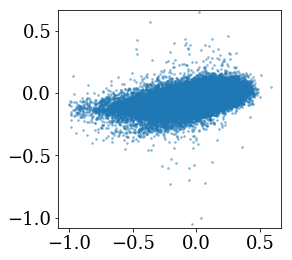

In [41]:
plt.figure(figsize=(4,4))
plt.scatter(Ydata, newY, s=3, alpha=0.4)
plt.ylim(plt.xlim())

(-1.0819262972727413, 0.6647018304720514)

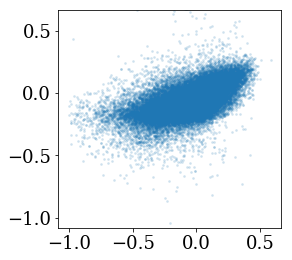

In [42]:
# our modestly less bad model
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(5), LinearRegression())

poly_model.fit(Xdata, Ydata)
newY = poly_model.predict(Xdata)

plt.figure(figsize=(4,4))
plt.scatter(Ydata, newY, s=3, alpha=0.14)
# plt.xlim(-.5,.5)
plt.ylim(plt.xlim())

(-1.0819262972727413, 0.6647018304720514)

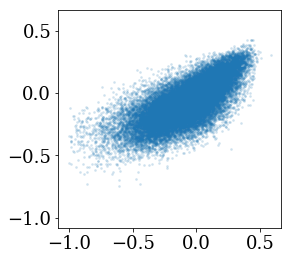

In [43]:
model = KNeighborsRegressor(n_neighbors=5)

model.fit(Xdata, Ydata)
newY = model.predict(Xdata)

plt.figure(figsize=(4,4))
plt.scatter(Ydata, newY, s=3, alpha=0.14)
# plt.xlim(-.5,.5)
plt.ylim(plt.xlim())

In [44]:
from scipy.stats import binned_statistic

Text(0,0.5,'STD')

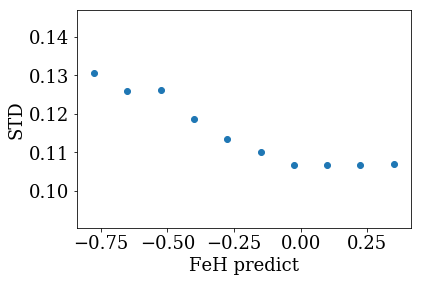

In [45]:
stds,bes, bn = binned_statistic(Ydata,newY, statistic='std', bins=10, range=(-0.9,0.35))

STD_predict = np.interp(newY, (bes[1:]+bes[:-1])/2., stds)

plt.scatter(bes[1:],stds)
plt.xlabel('FeH predict')
plt.ylabel('STD')

In [46]:
np.interp(-2.5, (bes[1:]+bes[:-1])/2., stds)

0.13056065875121675

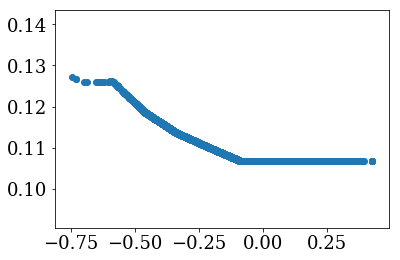

In [47]:
plt.scatter(newY, STD_predict)

In [48]:
from sklearn.cross_validation import train_test_split

/Users/james/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [49]:
x_train, x_test, y_train, y_test = train_test_split(Xdata, Ydata)

(-1.0640639475241298, 0.6638512423887842)

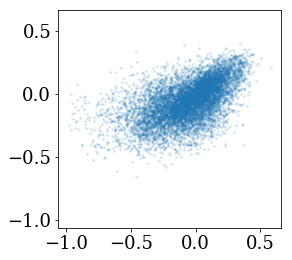

In [50]:
model = KNeighborsRegressor(n_neighbors=5)

model.fit(x_train, y_train)
newY = model.predict(x_test)

plt.figure(figsize=(4,4))
plt.scatter(y_test, newY, s=3, alpha=0.14)
# plt.xlim(-.5,.5)
plt.ylim(plt.xlim())

# Output
dump the data used specifically in this model as a small file

In [51]:
print(len(Mok[0]))

35210


In [52]:
df_out = pd.DataFrame(data={'w1':Adata[u'W1mag'].values[Aok][Bok][Mok],
                            'w2':Adata[u'W2mag'].values[Aok][Bok][Mok],
                            'phot_g_mean_mag':Adata[u'phot_g_mean_mag'].values[Aok][Bok][Mok],
                            'Jmag':Adata[u'Jmag'].values[Aok][Bok][Mok],
                            'M_G':M_GA[Bok][Mok],
                            'FE_H':Adata[u'FE_H'].values[Aok][Bok][Mok]})

df_out.to_csv('ingot_data.csv', index=False, index_label=False)

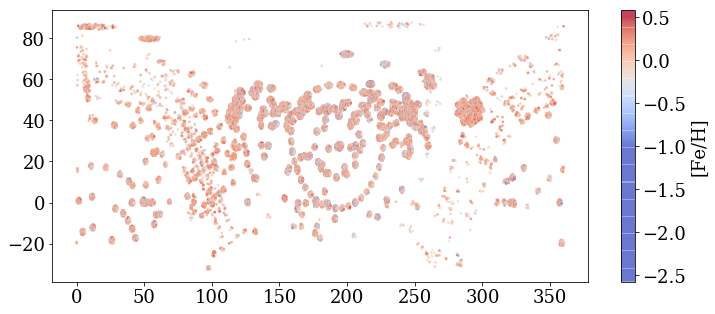

In [53]:
plt.figure(figsize=(12,5))

plt.scatter(Adata[u'RA'].values[Aok][Bok],
            Adata[u'DEC'].values[Aok][Bok],
            c=Adata[u'FE_H'].values[Aok][Bok], s=3, alpha=0.5, cmap=plt.cm.coolwarm)

cb = plt.colorbar()
cb.set_label('[Fe/H]')
cb.set_clim(-1,0.5)


In [54]:
# plt.scatter(Adata[u'W2mag'].values[Aok][Bok], Adata[u'e_W2mag'].values[Aok][Bok],
#             s=3, alpha=0.3)

In [55]:
def FeH(w1w2, GJ, MG, use_MG = False):
    '''
    Predict the [Fe/H] value for stars given their (W1-W2, G-J) colors.

    Using: KNN regression, trained on a sample of stars from APOGEE (included).

    Errors estimates come from the scatter in the prediction of the
    original training data.

    Optionally (recommended!): Include the Gaia Absolute G mag in the KNN model
    '''
    
    df = pd.read_csv('ingot_data.csv.gz')

    if use_MG:
        Xdata = np.array([df['w1'].values - df[u'w2'].values,
                         df[u'phot_g_mean_mag'].values - df[u'Jmag'].values,
                         df[u'M_G'].values]).T
        Xdata_input = np.array([w1w2, GJ, MG]).T
    else:
        Index([u'FE_H', u'Jmag', u'M_G', u'phot_g_mean_mag', u'w1', u'w2'], dtype='object')
        Xdata = np.array([df['w1'].values - df[u'w2'].values,
                         df[u'phot_g_mean_mag'].values - df[u'Jmag'].values]).T
        Xdata_input = np.array([w1w2, GJ]).T

    Ydata = df[u'FE_H'].values

    # Build the KNN model, as in the Gaia Sprint (2018) notebook
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(Xdata, Ydata)
    newY = model.predict(Xdata)

    FeH_predict = model.predict(Xdata_input)

    # use scatter to estimate errors on the prediction of the KNN
    # NOTE: this does not include observational errors, only an estimate
    stds, bes, _ = binned_statistic(Ydata,newY, statistic='std', bins=10, range=(-0.9,0.35))
    FeH_predict_err = np.interp(FeH_predict, (bes[1:]+bes[:-1])/2., stds)


    return FeH_predict, FeH_predict_err

## New Data

In [44]:
nf = pd.read_csv('/Users/james/Desktop/gaia_tmp/gaia_apogee1.csv')

In [45]:
print(nf.shape)

(5182794, 65)


In [46]:
# nf.columns

/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/james/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater


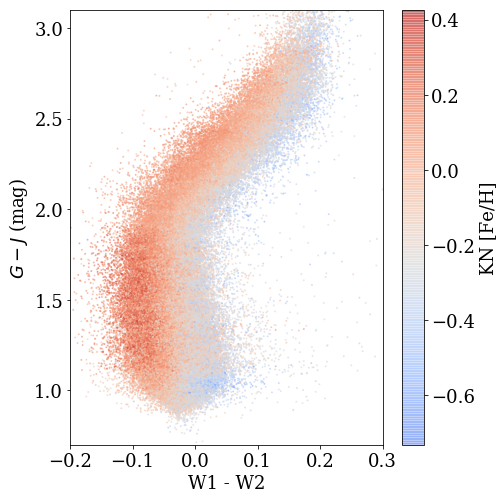

In [138]:
nM_G = (nf[u'phot_g_mean_mag'].values - 
       5*np.log10(1000./nf[u'parallax'].values)+5)

nok = np.where((nf[u'e_W2mag'] <= 0.05) & (nf[u'W2mag'] < 14) & 
               np.isfinite(nf[u'a_g_val']) & 
               (nM_G > 4) &
               np.isfinite(nM_G) & 
               np.isfinite(nf[u'W1mag']) & 
               np.isfinite(nf[u'W2mag']) & 
               np.isfinite(nf[u'Jmag']) & 
               (nf[u'a_g_val'] < 0.5) & 
               (nf[u'parallax_error']/nf[u'parallax'] < 0.1))[0]

yy,ye = FeH(nf[u'W1mag'].values[nok] - nf[u'W2mag'].values[nok], 
            nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok], 
            nM_G[nok], use_MG=True)

# X_NEW_DATA = np.array([nf[u'W1mag'].values[nok] - nf[u'W2mag'].values[nok],
#                        nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok], 
#                        nM_G[nok]]).T
# NEW_FE_H = model.predict(X_NEW_DATA)

NEW_FE_H = yy

plt.figure(figsize=(7,8))

plt.scatter(nf[u'W1mag'].values[nok] - nf[u'W2mag'].values[nok],
            nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok],
            s=1, alpha=0.5, c=NEW_FE_H, cmap=plt.cm.coolwarm)

# plt.plot(np.polyval(fit,np.arange(0,3.2,0.1)), np.arange(0,3.2,0.1), c='r')

plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

cb = plt.colorbar()
cb.set_label('KN [Fe/H]')
cb.set_clim(-1,0.5)

In [139]:
print(NEW_FE_H.shape)

(199363,)


Text(0,0.5,'$M_G$ (mag)')

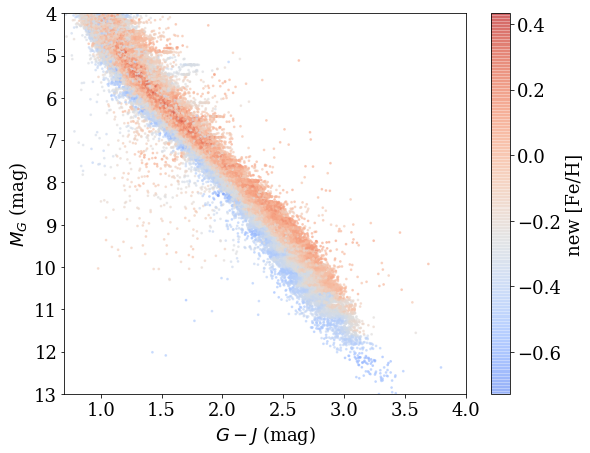

In [49]:
plt.figure(figsize=(9,7))

plt.scatter(nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok],
            nM_G[nok],
            s=3, alpha=0.5, cmap = plt.cm.coolwarm,
            c = NEW_FE_H)

cb = plt.colorbar()
cb.set_label('new [Fe/H]')
cb.set_clim(-1,0.5)

plt.ylim(13,4)
plt.xlim(.7,4)
plt.xlabel('$G-J$ (mag)')
plt.ylabel(r'$M_G$ (mag)')


In [51]:
# some problem with this file, multiple columns
# NEWdata = Table.read('/Users/james/Desktop/gaia_tmp/lowmass_wisedwarfs.fits', format='fits')

# had IDL read/write this file...
NEWdata = Table.read('/Users/james/Desktop/gaia_tmp/testout.fits', format='fits') 

In [69]:
# (NEWdata.colnames)

In [63]:
# NEWdata

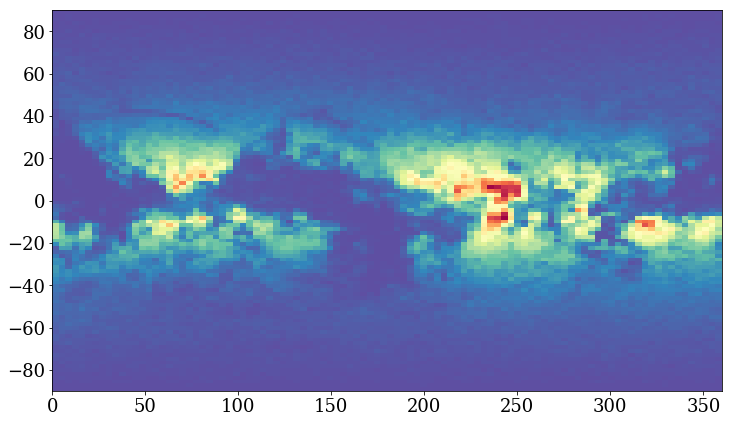

In [67]:
plt.figure(figsize=(12,7))
_ = plt.hist2d(NEWdata['L'], NEWdata['B'], bins=100, cmap=plt.cm.Spectral_r)

In [ ]:
nM_G = (nf[u'phot_g_mean_mag'].values - 
       5*np.log10(1000./nf[u'parallax'].values)+5)

nok = np.where((nf[u'e_W2mag'] <= 0.05) & (nf[u'W2mag'] < 14) & 
               np.isfinite(nf[u'a_g_val']) & 
               (nM_G > 4) &
               np.isfinite(nM_G) & 
               np.isfinite(nf[u'W1mag']) & 
               np.isfinite(nf[u'W2mag']) & 
               np.isfinite(nf[u'Jmag']) & 
               (nf[u'a_g_val'] < 0.5) & 
               (nf[u'parallax_error']/nf[u'parallax'] < 0.1))[0]


X_NEW_DATA = np.array([nf[u'W1mag'].values[nok] - nf[u'W2mag'].values[nok],
                       nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok], 
                       nM_G[nok]]).T
NEW_FE_H = model.predict(X_NEW_DATA)


plt.figure(figsize=(7,8))

plt.scatter(nf[u'W1mag'].values[nok] - nf[u'W2mag'].values[nok],
            nf[u'phot_g_mean_mag'].values[nok] - nf[u'Jmag'].values[nok],
            s=1, alpha=0.5, c=NEW_FE_H, cmap=plt.cm.coolwarm)

# plt.plot(np.polyval(fit,np.arange(0,3.2,0.1)), np.arange(0,3.2,0.1), c='r')

plt.xlim(-0.2,0.3)
plt.ylim(0.7, 3.1)
plt.xlabel('W1 - W2')
plt.ylabel('$G-J$ (mag)')

cb = plt.colorbar()
cb.set_label('KN [Fe/H]')
cb.set_clim(-1,0.5)